In [1]:
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.model_selection import GridSearchCV

#Import all the models that I will use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'song_classifier',    # DB that we are connecting to
}
connection = pg.connect(**connection_args)

In [3]:
query = "SELECT * FROM songs_of_the_60s\
        UNION \
        SELECT * FROM songs_of_the_70s\
        UNION\
        SELECT * FROM songs_of_the_80s\
        UNION\
        SELECT * FROM songs_of_the_90s\
        UNION\
        SELECT * FROM songs_of_the_00s\
        UNION\
        SELECT * FROM songs_of_the_10s;"

songs_df = pd.read_sql(query, connection)
songs_df.shape

(41106, 20)

## Run features 

In [4]:
X = songs_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_df['target'].values

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
ks = list(range(1,51))

param_grid = dict(n_neighbors = ks)

nn = KNeighborsClassifier()

grid = GridSearchCV(nn, param_grid, cv = 5, scoring = 'accuracy',verbose=1)
grid.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  8.8min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=1)

In [10]:
grid.best_params_

{'n_neighbors': 28}

In [11]:
nn = KNeighborsClassifier(n_neighbors=28,n_jobs=-1)

nn_classifier = nn.fit(X_train_scaled,y_train)

print("kNN confusion matrix: \n\n", confusion_matrix(y_test, nn.predict(X_test_scaled)))

kNN confusion matrix: 

 [[2555 1609]
 [ 512 3546]]


In [12]:
nn.score(X_val_scaled,y_val)

0.7469085749037098

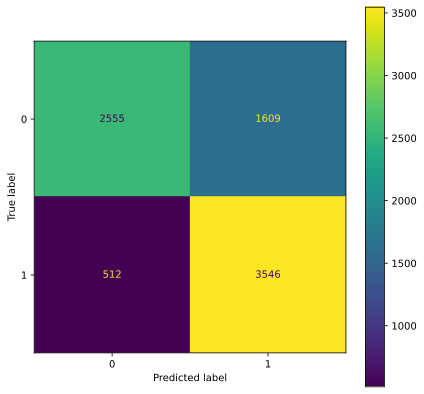

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn_classifier,X_test_scaled, y_test, ax=ax)

## Logisitc Regression

In [15]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.66      0.70      4885
           1       0.70      0.80      0.75      4981

    accuracy                           0.73      9866
   macro avg       0.73      0.73      0.73      9866
weighted avg       0.73      0.73      0.73      9866



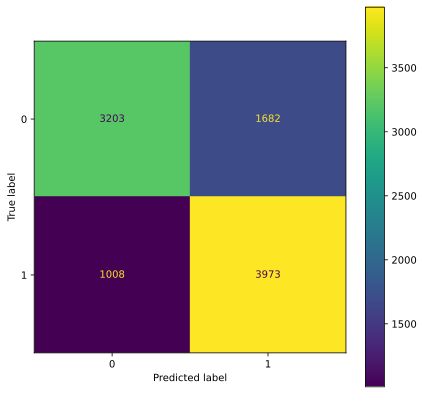

In [16]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

In [17]:
lr.score(X_val_scaled,y_val)

0.7273464423271843

 ## 1960 prediction

In [3]:
query = "SELECT * FROM songs_of_the_60s;"
songs_60s_df = pd.read_sql(query, connection)

In [4]:
X = songs_60s_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_60s_df['target'].values

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

sixties_train_score = lr.score(X_train_scaled,y_train)
sixties_val_score = lr.score(X_val_scaled,y_val)
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       963
           1       0.66      0.79      0.72       901

    accuracy                           0.70      1864
   macro avg       0.71      0.70      0.70      1864
weighted avg       0.71      0.70      0.70      1864

Logistic Regression train score: 0.724
Logistic Regression test score: 0.700


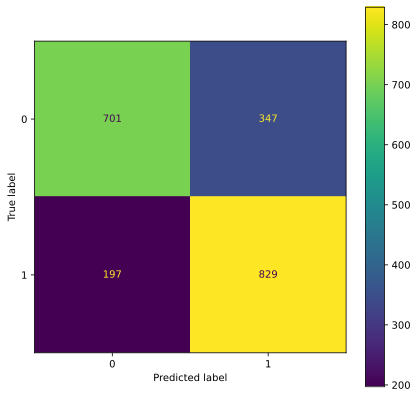

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

## 1970 prediction

In [18]:
query = "SELECT * FROM songs_of_the_70s;"
songs_70s_df = pd.read_sql(query, connection)

In [19]:
X = songs_70s_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_70s_df['target'].values

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [22]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

seventies_train_score = lr.score(X_train_scaled,y_train)
seventies_val_score = lr.score(X_val_scaled,y_val)
print(classification_report(y_val, y_preds))
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

              precision    recall  f1-score   support

           0       0.74      0.61      0.67       938
           1       0.67      0.78      0.72       926

    accuracy                           0.70      1864
   macro avg       0.70      0.70      0.69      1864
weighted avg       0.70      0.70      0.69      1864

Logistic Regression train score: 0.720
Logistic Regression test score: 0.696


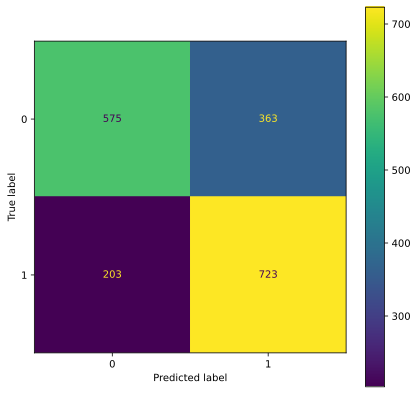

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

## 1980 prediction

In [54]:
query = "SELECT * FROM songs_of_the_80s;"
songs_80s_df = pd.read_sql(query, connection)

In [55]:
X = songs_80s_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_80s_df['target'].values

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [58]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

eighties_train_score = lr.score(X_train_scaled,y_train)
eighties_val_score = lr.score(X_val_scaled,y_val)
print(classification_report(y_val, y_preds))
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       815
           1       0.75      0.82      0.79       843

    accuracy                           0.77      1658
   macro avg       0.77      0.77      0.77      1658
weighted avg       0.77      0.77      0.77      1658

Logistic Regression train score: 0.773
Logistic Regression test score: 0.771


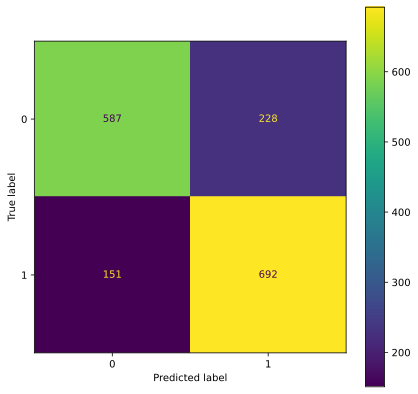

In [59]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

## 1990 prediction

In [60]:
query = "SELECT * FROM songs_of_the_90s;"
songs_90s_df = pd.read_sql(query, connection)

In [61]:
X = songs_90s_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_90s_df['target'].values

In [62]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [64]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

nineties_train_score = lr.score(X_train_scaled,y_train)
nineties_val_score = lr.score(X_val_scaled,y_val)
print(classification_report(y_val, y_preds))
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       637
           1       0.79      0.87      0.83       688

    accuracy                           0.82      1325
   macro avg       0.82      0.81      0.81      1325
weighted avg       0.82      0.82      0.81      1325

Logistic Regression train score: 0.806
Logistic Regression test score: 0.815


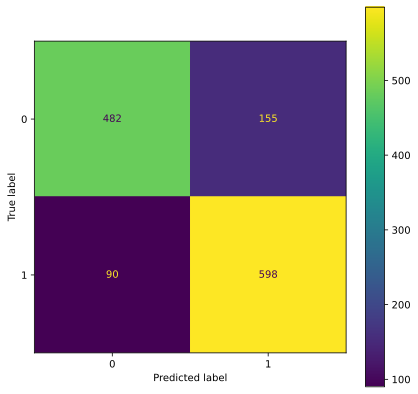

In [65]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

### 2000s predictions

In [84]:
query = "SELECT * FROM songs_of_the_00s;"
songs_00s_df = pd.read_sql(query, connection)

In [85]:
X = songs_00s_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_00s_df['target'].values

In [86]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [88]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

two_thousands_train_score = lr.score(X_train_scaled,y_train)
two_thousands_val_score = lr.score(X_val_scaled,y_val)
print(classification_report(y_val, y_preds))
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       705
           1       0.79      0.88      0.83       705

    accuracy                           0.82      1410
   macro avg       0.82      0.82      0.82      1410
weighted avg       0.82      0.82      0.82      1410

Logistic Regression train score: 0.831
Logistic Regression test score: 0.820


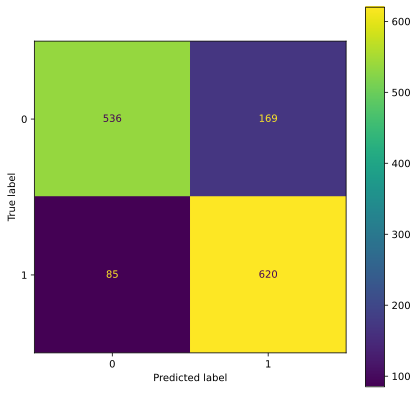

In [89]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

## 2010s

In [90]:
query = "SELECT * FROM songs_of_the_10s;"
songs_10s_df = pd.read_sql(query, connection)

In [91]:
X = songs_10s_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_10s_df['target'].values

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [93]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [114]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

twenty_tens_train_score = lr.score(X_train_scaled,y_train)
twenty_tens_val_score = lr.score(X_val_scaled,y_val)
print(classification_report(y_val, y_preds))
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

              precision    recall  f1-score   support

           0       0.86      0.74      0.79       763
           1       0.77      0.89      0.83       773

    accuracy                           0.81      1536
   macro avg       0.82      0.81      0.81      1536
weighted avg       0.82      0.81      0.81      1536

Logistic Regression train score: 0.807
Logistic Regression test score: 0.811


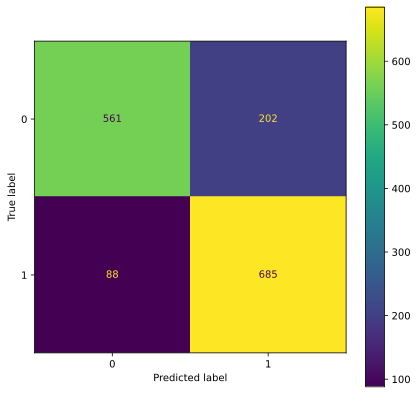

In [95]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

## Plot prediction scores across decades

In [107]:
import numpy as np
decades = np.array([1960,1970,1980,1990,2000,2010])


In [108]:
decade_train_scores = np.array([sixties_train_score,seventies_train_score,eighties_train_score,nineties_train_score,\
                       two_thousands_train_score,twenty_tens_train_score])
decade_val_scores = np.array([sixties_val_score,seventies_val_score,eighties_val_score,nineties_val_score,\
                       two_thousands_val_score,twenty_tens_val_score]) 

In [111]:
df=pd.DataFrame({'x': decades, 'y1': decade_val_scores, 'y2': decade_train_scores})

<ipython-input-112-d87f53fb0739>:1: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
<ipython-input-112-d87f53fb0739>:2: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)


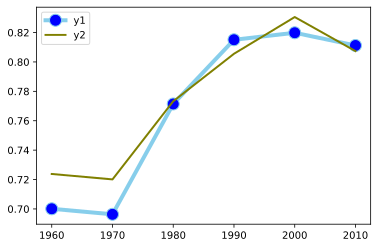

In [112]:
plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
plt.legend()
